In [1]:
import numpy as np
import pandas as pd
import json
from PIL import Image
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [3]:
resampled_df = pd.read_json("rail_points.json")
resampled_df = resampled_df.T
resampled_df.index = resampled_df.index.str.replace('.jpg', '')
resampled_df.head()

,left_rail,right_rail
rs00000,"[[901, 1079], [902, 1070], [903, 1060], [904, ...","[[1166, 1079], [1164, 1071], [1160, 1062], [11..."
rs00002,"[[612, 1079], [616, 1072], [622, 1064], [626, ...","[[887, 1079], [887, 1069], [888, 1060], [889, ..."
rs00003,"[[619, 1079], [622, 1071], [624, 1061], [626, ...","[[903, 1079], [901, 1071], [899, 1062], [896, ..."
rs00004,"[[949, 1079], [949, 1069], [949, 1059], [949, ...","[[1279, 1079], [1274, 1072], [1270, 1064], [12..."
rs00005,"[[647, 1079], [650, 1071], [654, 1062], [657, ...","[[945, 1079], [944, 1070], [943, 1061], [941, ..."


In [4]:
# Path to the directory containing the original images
image_directory = 'rs19_val/'
cropped_image_directory = 'rs19_val_crop/'
os.makedirs(cropped_image_directory, exist_ok=True)

In [14]:
# Iterate over images in the JSON data, only to excute once
for image_name, image_data in resampled.items():
    image_id = image_name.split('.')[0]  # Extract the image ID (e.g., "00000")
    image_path = os.path.join(image_directory, image_name)

    # Get the coordinates of the bounding box
    left_top = (min(image_data['left_rail'], key=lambda x: x[0])[0], min(image_data['left_rail'], key=lambda x: x[1])[1])
    right_bottom = (max(image_data['right_rail'], key=lambda x: x[0])[0], max(image_data['right_rail'], key=lambda x: x[1])[1])

    # Open the original image
    original_image = Image.open(image_path)

    # Crop the region defined by the bounding box
    cropped_image = original_image.crop((left_top[0], left_top[1], right_bottom[0], right_bottom[1]))

    # Save the cropped image to the new directory
    cropped_image.save(os.path.join(cropped_image_directory, f'{image_id}.jpg'))

In [5]:
# Create a new directory for the resized images
resized_image_directory = 'rs19_val_cropped_resized/'
os.makedirs(resized_image_directory, exist_ok=True)

In [10]:
# Iterate over images in the cropped directory, only to excute once
for filename in os.listdir(cropped_image_directory)
    img = Image.open(os.path.join(cropped_image_directory, filename))
    img_resized = img.resize((300, 300))
    img_resized.save(os.path.join(resized_image_directory, filename))

In [6]:
# Create resampled_cropped_resized_df and resampled_cropped_resized_select_df with the same header
resampled_cropped_resized_df = copy.deepcopy(resampled_df)

# Create an empty list to store new rows
lefts = []
tops = []
lenth = 1
for image_name, image_data_resampled in resampled_df.iterrows():
    
    # Extract left and right rail points
    left_rail = image_data_resampled['left_rail']
    right_rail = image_data_resampled['right_rail']

    # Get extreme points to define the bounding box
    all_points = left_rail + right_rail
    min_x = min(point[0] for point in all_points)
    min_y = min(point[1] for point in all_points)
    max_x = max(point[0] for point in all_points)
    max_y = max(point[1] for point in all_points)

    # Define the bounding box
    left = min_x
    top = min_y
    right = max_x
    bottom = max_y
    width = right - left + 1
    height = bottom - top + 1

    # Create deep copies of left_rail and right_rail to avoid modifying the original DataFrame
    left_rail_copy = copy.deepcopy(left_rail)
    right_rail_copy = copy.deepcopy(right_rail)

    for i in range(len(left_rail_copy)):
        left_rail_copy[i][0] = (left_rail[i][0] - left) * 300 / width
        left_rail_copy[i][1] = (left_rail[i][1] - top) * 300 / height

    for i in range(len(right_rail_copy)):
        right_rail_copy[i][0] = (right_rail[i][0] - left) * 300 / width
        right_rail_copy[i][1] = (right_rail[i][1] - top) * 300 / height

    # Update the new DataFrame with the modified rail coordinates
    resampled_cropped_resized_df.loc[image_name, 'left_rail'] = left_rail_copy
    resampled_cropped_resized_df.loc[image_name, 'right_rail'] = right_rail_copy

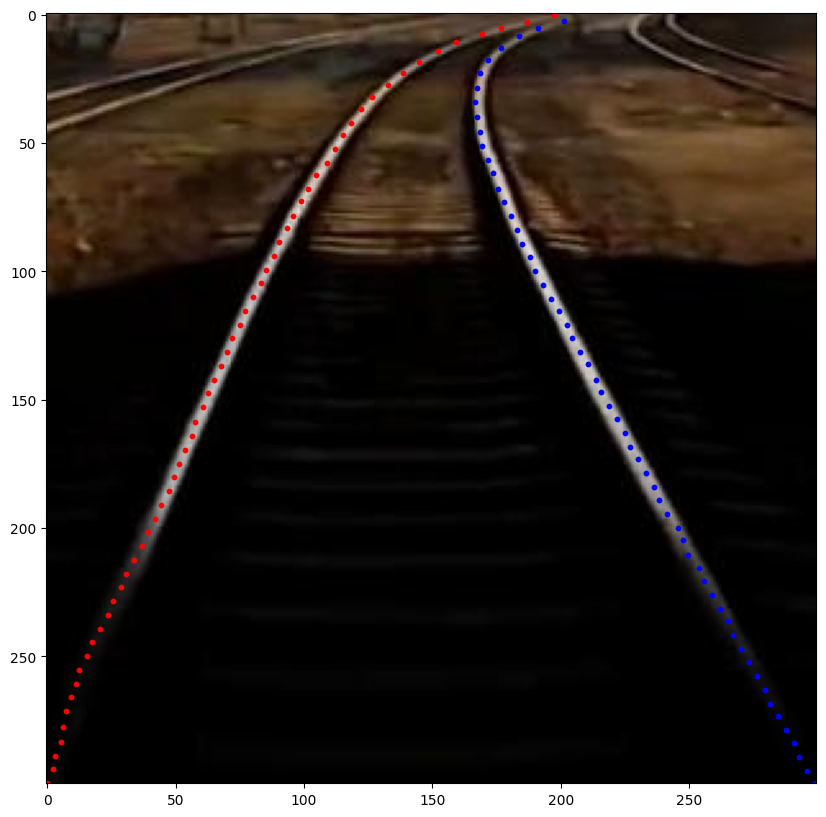

In [7]:
# Visualize the cropped coordinates on the cropped  and resized images

# Select a random row
random_index = np.random.choice(resampled_cropped_resized_df.index)
# random_row = resampled_cropped_resized_df.loc[random_index]

# Get the corresponding image filename
image_filename = f'{random_index}.jpg'  # Assuming the images are named with their index + '.jpg'

# Load the image
image_path = os.path.join('rs19_val_cropped_resized', image_filename)
image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Plot left and right rail coordinates of resampled_cropped_resized_df on the image
# Example plotting the left rail coordinates as red dots and right rail coordinates as blue dots
for coord in resampled_cropped_resized_df.loc[random_index]['left_rail']:
    plt.scatter(coord[0], coord[1], color='red', s=10)  # Adjust the size 's' as needed

for coord in resampled_cropped_resized_df.loc[random_index]['right_rail']:
    plt.scatter(coord[0], coord[1], color='blue', s=10)  # Adjust the size 's' as needed

In [8]:
# Initialize the new DataFrame with the same index as 'resampled_cropped_resized_df'
resampled_cropped_resized_interpolated_df = pd.DataFrame(index=resampled_cropped_resized_df.index)

# Number of interpolation points
num_interpolation_points = 50

# Create columns for 'left_rail'
for i in range(num_interpolation_points):
    x_column_name = f'left_rail_x{i+1}'
    y_column_name = f'left_rail_y{i+1}'
    resampled_cropped_resized_interpolated_df[x_column_name] = 0
    resampled_cropped_resized_interpolated_df[y_column_name] = 0

# Create columns for 'right_rail'
for i in range(num_interpolation_points):
    x_column_name = f'right_rail_x{i+1}'
    y_column_name = f'right_rail_y{i+1}'
    resampled_cropped_resized_interpolated_df[x_column_name] = 0
    resampled_cropped_resized_interpolated_df[y_column_name] = 0

C:\Users\Dfan\AppData\Local\Temp\ipykernel_23120\3305124243.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_cropped_resized_interpolated_df[x_column_name] = 0
C:\Users\Dfan\AppData\Local\Temp\ipykernel_23120\3305124243.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_cropped_resized_interpolated_df[y_column_name] = 0
C:\Users\Dfan\AppData\Local\Temp\ipykernel_23120\3305124243.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [9]:
for image_name, image_data_resampled_cropped_resized in resampled_cropped_resized_df.iterrows():
    # Interpolate
    y_new = np.linspace(0, 299, num_interpolation_points)  # CORRECTED: 299 instead of 300, remember that linspace includes the last value
    left_rail = image_data_resampled_cropped_resized['left_rail']
    right_rail = image_data_resampled_cropped_resized['right_rail']
    x_new_left = np.interp(y_new, np.array(image_data_resampled_cropped_resized['left_rail'])[:, 1][::-1], np.array(image_data_resampled_cropped_resized['left_rail'])[:, 0][::-1])
    x_new_right = np.interp(y_new, np.array(image_data_resampled_cropped_resized['right_rail'])[:, 1][::-1], np.array(image_data_resampled_cropped_resized['right_rail'])[:, 0][::-1])

    # Assign the interpolated corrdinates in resampled_cropped_resized_interpolated_df
    for i in range(num_interpolation_points):
        x_column_name_left = f'left_rail_x{i+1}'
        y_column_name_left = f'left_rail_y{i+1}'

        x_column_name_right = f'right_rail_x{i+1}'
        y_column_name_right = f'right_rail_y{i+1}'

        # Assign the interpolated coordinates to the new DataFrame
        resampled_cropped_resized_interpolated_df.loc[image_name, x_column_name_left] = round(x_new_left[i])  #  CORRECTED: round() added + loc to assign the value to the right cell
        resampled_cropped_resized_interpolated_df.loc[image_name, y_column_name_left] = round(y_new[i])  #  CORRECTED: round() added + loc to assign the value to the right cell

        resampled_cropped_resized_interpolated_df.loc[image_name, x_column_name_right] = round(x_new_right[i])  #  CORRECTED: round() added + loc to assign the value to the right cell
        resampled_cropped_resized_interpolated_df.loc[image_name, y_column_name_right] = round(y_new[i])  #  CORRECTED: round() added + loc to assign the value to the right cell


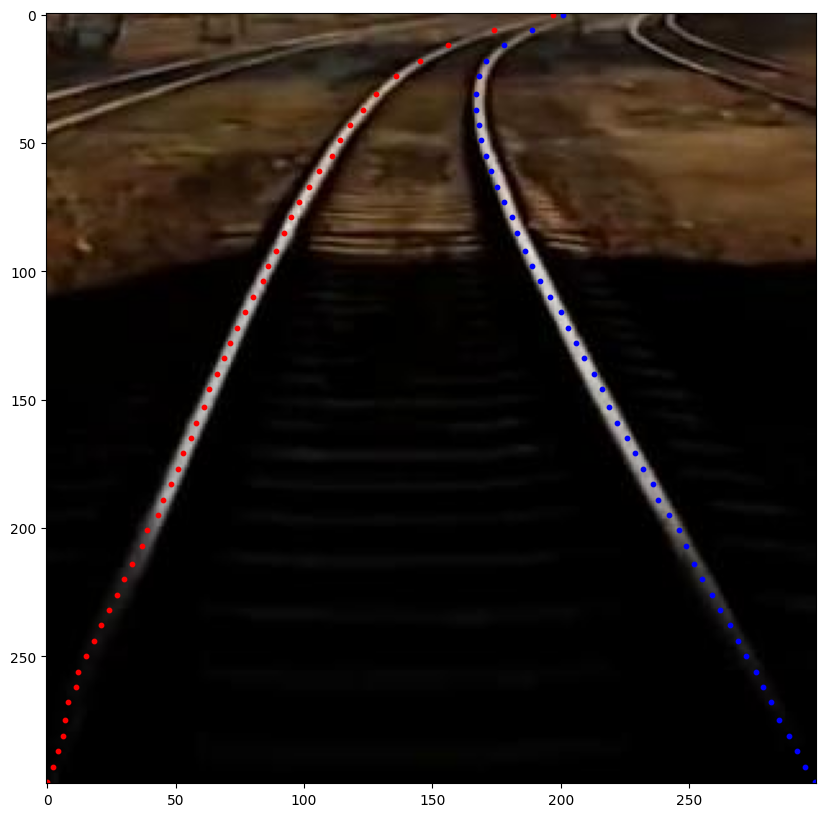

In [10]:
# Re-visualize the cropped coordinates on the cropped  and resized, interpolated images

# Get the corresponding image filename
image_filename = f'{random_index}.jpg'  # Assuming the images are named with their index + '.jpg'

# Load the image
image_path = os.path.join('rs19_val_cropped_resized', image_filename)
image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Plot left and right rail coordinates of resampled_cropped_resized_df on the image
# Example plotting the left rail coordinates as red dots and right rail coordinates as blue dots
points = np.array(resampled_cropped_resized_interpolated_df.loc[random_index])
for i in range(num_interpolation_points):
    plt.scatter(points[2*i], points[2*i+1], color='red', s=10)  # Left rail, Adjust the size 's' as needed
    plt.scatter(points[2*i+num_interpolation_points*2], points[2*i+1+num_interpolation_points*2], color='blue', s=10)  # Right rail, Adjust the size 's' as needed
        


In [11]:
resampled_cropped_resized_interpolated_df.head()

,left_rail_x1,left_rail_y1,left_rail_x2,left_rail_y2,left_rail_x3,left_rail_y3,left_rail_x4,left_rail_y4,left_rail_x5,left_rail_y5,...,right_rail_x46,right_rail_y46,right_rail_x47,right_rail_y47,right_rail_x48,right_rail_y48,right_rail_x49,right_rail_y49,right_rail_x50,right_rail_y50
rs00000,182,0,142,6,118,12,103,18,93,24,...,282,275,286,281,290,287,295,293,299,299
rs00002,198,0,233,6,252,12,258,18,260,24,...,274,275,274,281,273,287,272,293,272,299
rs00003,140,0,137,6,134,12,131,18,128,24,...,287,275,289,281,293,287,296,293,299,299
rs00004,0,0,28,6,44,12,56,18,64,24,...,284,275,288,281,291,287,295,293,299,299
rs00005,202,0,199,6,194,12,190,18,186,24,...,291,275,294,281,296,287,298,293,299,299


In [12]:
resampled_cropped_resized_interpolated_df.to_csv('rail.csv')